# ATM433 Final Project: Effects of Winter North Atlantic Oscillation on Oceans

## Imports

In [30]:
import xarray as xr
import pandas as pd
import geopandas as gp
import numpy as np
import seaborn

from datetime import datetime as dt
from metpy.units import units
from metpy import calc as mpcalc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import requests
from pathlib import Path

import contextily as ctx

import statistics

## North Atlantic Oscillation, Quantified

Data taken from NOAA https://www.ncdc.noaa.gov/teleconnections/nao/

First, I get my data from NOAA site; data is given in ASCII table form, so I convert to a DataFrame

In [31]:
NAO_url ='https://www.cpc.ncep.noaa.gov/products/precip/CWlink/pna/norm.nao.monthly.b5001.current.ascii.table'
dfNAO = pd.read_table(NAO_url, sep="\s+") #NAO DataFrame
dfNAO

,1950,0.92,0.40,-0.36,0.73,-0.59,-0.06,-1.26,-0.05,0.25,0.85,-1.26.1,-1.02
0,1951,0.08,0.70,-1.02,-0.22,-0.59,-1.64,1.37,-0.22,-1.36,1.87,-0.39,1.32
1,1952,0.93,-0.83,-1.49,1.01,-1.12,-0.40,-0.09,-0.28,-0.54,-0.73,-1.13,-0.43
2,1953,0.33,-0.49,-0.04,-1.67,-0.66,1.09,0.40,-0.71,-0.35,1.32,1.04,-0.47
3,1954,0.37,0.74,-0.83,1.34,-0.09,-0.25,-0.60,-1.90,-0.44,0.60,0.40,0.69
4,1955,-1.84,-1.12,-0.53,-0.42,-0.34,-1.10,1.76,1.07,0.32,-1.47,-1.29,0.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,2017,0.48,1.00,0.74,1.73,-1.91,0.05,1.26,-1.10,-0.61,0.19,-0.00,0.88
67,2018,1.44,1.58,-0.93,1.24,2.12,1.09,1.39,1.97,1.67,0.93,-0.11,0.61
68,2019,0.59,0.29,1.23,0.47,-2.62,-1.09,-1.43,-1.17,-0.16,-1.41,0.28,1.20
69,2020,1.34,1.26,1.01,-1.02,-0.41,-0.15,-1.23,0.12,0.98,-0.65,2.54,-0.30


Since the top row is treating the first row of data (from 1950) as column labels, I'm going to manually replace them using .rename() -- I tried many other methods of doing this, and this, although a little tedious, was the only one that worked. Also, I'm going to subset the data anyway, so no worries about losing data from 1950.

In [32]:
dfNAO.columns

Index(['1950', '0.92', '0.40', '-0.36', '0.73', '-0.59', '-0.06', '-1.26',
       '-0.05', '0.25', '0.85', '-1.26.1', '-1.02'],
      dtype='object')

In [33]:
dfNAO=dfNAO.rename({'1950':'Year','0.92':'Jan', '0.40':'Feb', '-0.36':'Mar', '0.73':'Apr', '-0.59':'May', '-0.06':'Jun', '-1.26':'Jul', '-0.05':'Aug', '0.25':'Sep', '0.85':'Oct', '-1.26.1':'Nov', '-1.02':'Dec' }, axis='columns')

Since the data is taken by year, I'm going to shift the December column up by one, so that the values for each row represent a season instead of a year.

In [34]:
dfNAO.Dec = dfNAO.Dec.shift(1)

Subsetting data for just the 2000s winter seasons, for more clarity

In [35]:
dfNAO=dfNAO.iloc[49:71]

In [36]:
columns = ['Year','Dec','Jan','Feb']

dfNAO = pd.DataFrame(dfNAO, columns=columns)
dfNAO

,Year,Dec,Jan,Feb
49,2000,1.61,0.60,1.70
50,2001,-0.58,0.25,0.45
51,2002,-0.83,0.44,1.10
52,2003,-0.94,0.16,0.62
53,2004,0.64,-0.29,-0.14
54,2005,1.21,1.52,-0.06
55,2006,-0.44,1.27,-0.51
56,2007,1.34,0.22,-0.47
57,2008,0.34,0.89,0.73
58,2009,-0.28,-0.01,0.06


### NAO VISUALIZATION: Group Bar Chart and Multiline Connected Point Chart

Instead of creating series objects to plot my graph (like I tried above), I plotted the dfNAO dataframe directly. My reference: https://www.geeksforgeeks.org/create-a-grouped-bar-plot-in-matplotlib/

It is a long line, but I like that plotting a DataFrame directly is fairly straightforward, and can be done in just one method.

In [37]:
plt.style.use('seaborn')

<AxesSubplot:title={'center':'Winter North Atlantic Oscillation (2000-2021)'}, xlabel='Year', ylabel='NAO Index'>

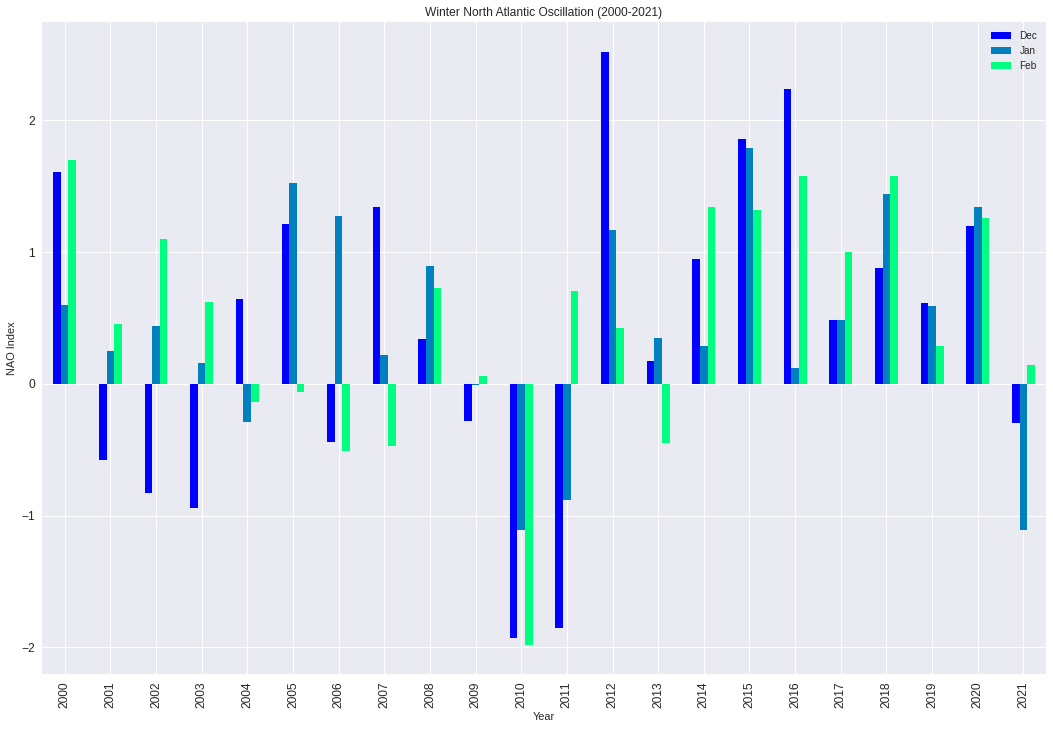

In [81]:
dfNAO.plot(x='Year', kind='bar', figsize=(18,12), stacked=False, title="Winter North Atlantic Oscillation (2000-2021)", ylabel="NAO Index", fontsize=12, colormap='winter')

Notice my use of the Winter colormap :)

Below is another supplementary graph to help illustrate NAO Indices in the 2010s.

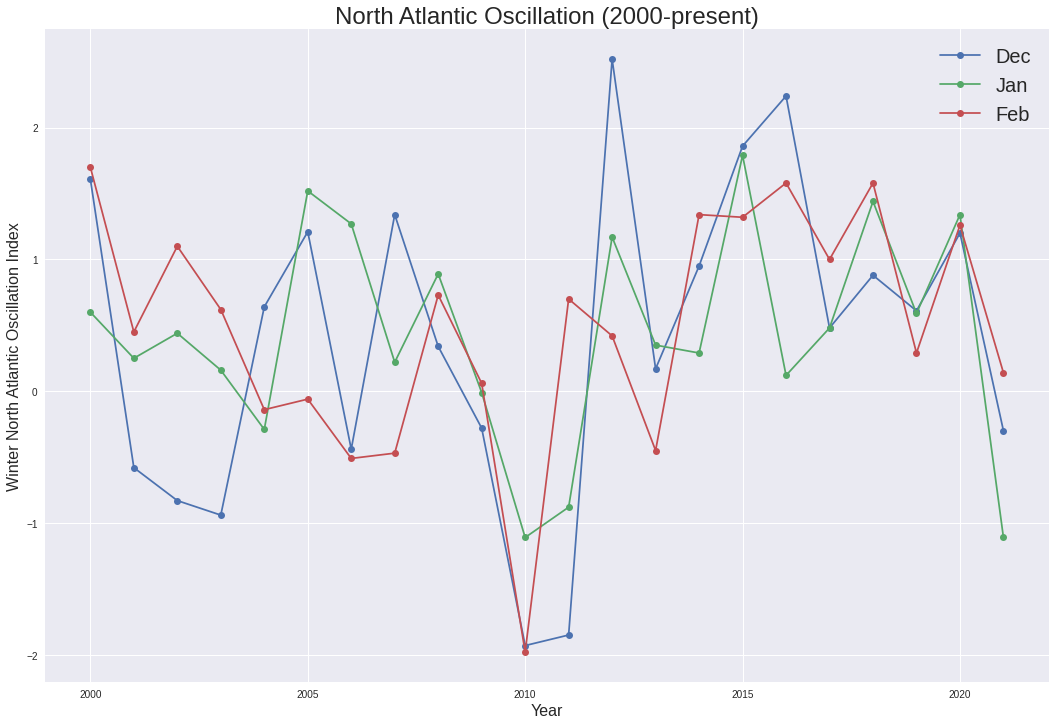

In [131]:
fig, ax = plt.subplots(figsize = (18,12))

#plt.gca().set_prop_cycle(['cyan','magenta','darkpurple'])

for months in dfNAO.columns:
    if not months == 'Year':
        plt.plot(dfNAO['Year'],dfNAO[months], "-o", label=str(months))
        
ax.set_xlabel('Year', fontsize=16)
ax.set_ylabel("Winter North Atlantic Oscillation Index", fontsize=16)
ax.set_title("North Atlantic Oscillation (2000-present)", fontsize=24)
ax.legend(loc='best', prop={'size': 20})

## Winter NAO Monthly Means

A simple graph, just to help quantify NAO index data

Since I'm taking a graph of means, I have to manipulate the data using some kind of mathematics method. I chose to go simple and use mean from the statistics import

In [87]:
dec = dfNAO['Dec']
jan = dfNAO['Jan']
feb = dfNAO['Feb']

a=statistics.mean(dec)
b=statistics.mean(jan)
c=statistics.mean(feb)

NAO_means= np.array([a,b,c])
NAO_means= pd.Series(NAO_means, index=["Dec","Jan","Feb"])

#seaborn.barplot(data=NAO_means,x=index, y="Mean NAO")

NAO_means

Dec    0.404545
Jan    0.432727
Feb    0.485455
dtype: float64

Since NAO_means is a Series type, I will convert it to a dataFrame.

In [88]:
dfNAO_means=NAO_means.to_frame()
dfNAO_means.columns=['Mean NAO Index']

I will use the DataFrame plot.bar() method to quickly make a simple graph

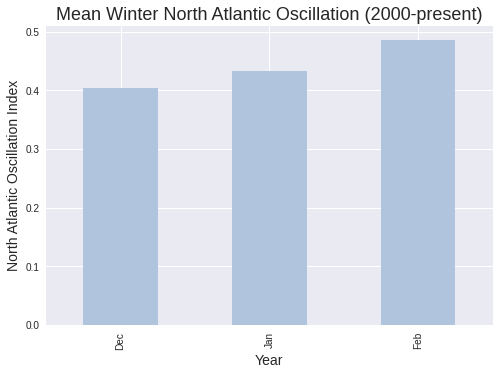

In [101]:
ax=dfNAO_means.plot.bar(color='lightsteelblue')

ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel("North Atlantic Oscillation Index", fontsize=14)
ax.set_title("Mean Winter North Atlantic Oscillation (2000-present)", fontsize=18)

ax.legend_.remove()

## Ocean Data: Sea Surface Height and Ocean Mixed Layer Thickness

I'm interested in the effects that NAO has on oceans. I used data from the SODA project: https://rda.ucar.edu/datasets/ds650.0/

Beginning with Data retrieval and creation of dsOcean dataset

In [41]:
ds_url_ocean = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds650.0/soda3_5dy_ocean_reg/2010_2019/soda3_5dy_ocean_reg_2015_01_04.nc'
HOME = str(Path.home())
credFile = open(HOME+'/.rdarc','r')
userId, pw = credFile.read().split()

session = requests.Session()
session.auth = (userId, pw)
store_ocean = xr.backends.PydapDataStore.open(ds_url_ocean, session=session)

In [42]:
dsOcean = xr.open_dataset(store_ocean)
dsOcean

<xarray.Dataset>
Dimensions:          (time: 1, xt_ocean: 720, yt_ocean: 330, xu_ocean: 720, yu_ocean: 330, st_ocean: 50, sw_ocean: 50)
Coordinates:
  * time             (time) datetime64[ns] 2015-01-04T13:00:00
  * xt_ocean         (xt_ocean) float64 0.25 0.75 1.25 ... 358.8 359.2 359.8
  * yt_ocean         (yt_ocean) float64 -74.75 -74.25 -73.75 ... 89.25 89.75
  * xu_ocean         (xu_ocean) float64 0.5 1.0 1.5 2.0 ... 359.0 359.5 360.0
  * yu_ocean         (yu_ocean) float64 -74.5 -74.0 -73.5 ... 89.0 89.5 90.0
  * st_ocean         (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * sw_ocean         (sw_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
Data variables: (12/26)
    temp             (time, st_ocean, yt_ocean, xt_ocean) float32 ...
    salt             (time, st_ocean, yt_ocean, xt_ocean) float32 ...
    wt               (time, sw_ocean, yt_ocean, xt_ocean) float32 ...
    ssh              (time, yt_ocean, xt_ocean) float32 ...
    mlt              (time, yt_ocean, xt_ocean) float32 ...
    mlp              (time, yt_ocean, xt_ocean) float32 ...
    ...               ...
    hflux_total_std  (time, yt_ocean, xt_ocean) float32 ...
    prho_std         (time, st_ocean, yt_ocean, xt_ocean) float32 ...
    u_std            (time, st_ocean, yu_ocean, xu_ocean) float32 ...
    v_std            (time, st_ocean, yu_ocean, xu_ocean) float32 ...
    taux_std         (time, yu_ocean, xu_ocean) float32 ...
    tauy_std         (time, yu_ocean, xu_ocean) float32 ...
Attributes:
    CDI:                             Climate Data Interface version 1.9.2 (ht...
    Conventions:                     CF-1.6
    history:                         combines up to six soda3 ensemble member...
    filename:                        soda3_5dy_ocean_reg_2015_01_04.nc
    title:                           soda3 ensemble mean and standard deviati...
    grid_type:                       mosaic
    grid_tile:                       1
    CDO:                             Climate Data Operators version 1.9.2 (ht...
    DODS_EXTRA.Unlimited_Dimension:  time

Subsetting data:

In [70]:
# Areal extent
lonW = -80.25
lonE = -5.25
latS = 20.25
latN = 70.25
latRange = np.arange(latS-5,latN+5,.5)
lonRange = np.arange((lonW-5+360),(lonE+5+360),.5)

# Date/Time specification
Year = 2015
Month = 1
Day = 4
Hour = 13
Minute = 0
dateTime = dt(Year,Month,Day, Hour, Minute)
timeStr = dateTime.strftime("%Y-%m-%d %H%M UTC")

Selecting variables: I'm interested in ocean mixed layer thickness (mlt) and sea surface height (ssh)

In [71]:
mlt = dsOcean['mlt'].sel(time=dateTime,yt_ocean=latRange,xt_ocean=lonRange)
ssh = dsOcean['ssh'].sel(time=dateTime,yt_ocean=latRange,xt_ocean=lonRange)

Checking dimensions for reference

In [72]:
print(mlt.shape)
print(mlt.units)
print(ssh.shape)
print(ssh.units)

(120, 170)
m
(120, 170)
meter


## Sea Surface Height and Ocean Mixed Layer Visualization

Onto the mapping! First I plot Mixed Layer Thickness

Text(0.5, 1.0, 'Mixed Layer Thickness (m) on 2015-01-04 1300 UTC')

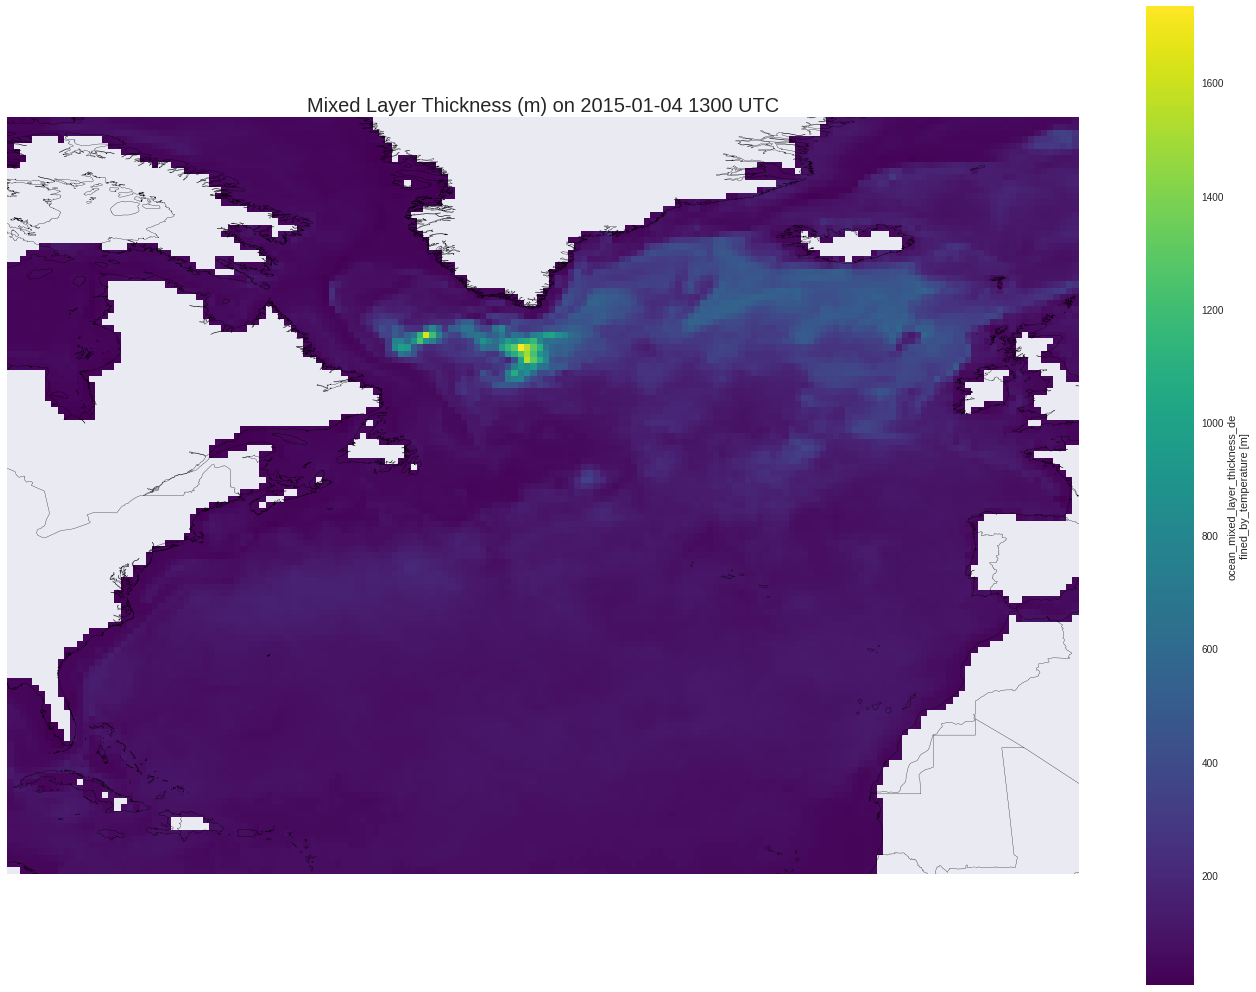

In [108]:
fig = plt.figure(figsize=(24,18))
ax = plt.axes(projection=ccrs.PlateCarree())

res='10m'
mlt.plot(ax=ax)

ax.coastlines(resolution=res)
ax.add_feature(cfeature.BORDERS.with_scale(res))

plt.title('Mixed Layer Thickness (m) on '+timeStr, fontsize = 20)

#ax.set_extent([-0, -30,30,60], ccrs.PlateCarree())

Next, is Sea Surface Height:

Text(0.5, 1.0, 'Sea Surface Height (m) on 2015-01-04 1300 UTC')

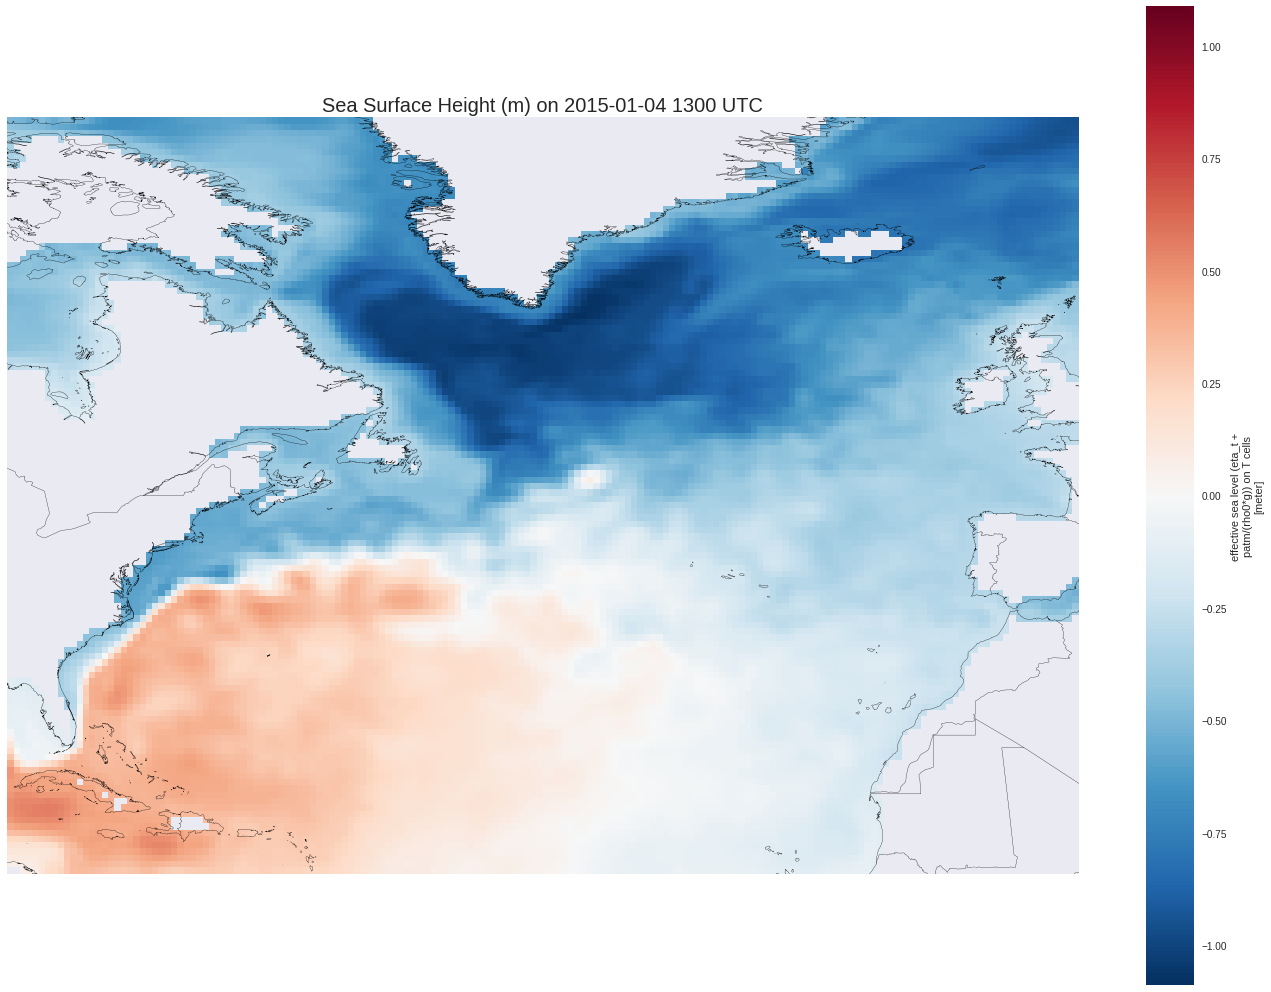

In [107]:
fig = plt.figure(figsize=(24,18))
ax = plt.axes(projection=ccrs.PlateCarree())

res='10m'
ssh.plot(ax=ax)

ax.coastlines(resolution=res)
ax.add_feature(cfeature.BORDERS.with_scale(res))

plt.title('Sea Surface Height (m) on '+timeStr, fontsize = 20)edi

#ax.set_extent([-0, -30,30,60], ccrs.PlateCarree())

Next, I will recreate these figures during 2010, when the NAO Oscillation was in a negative phase.

In [122]:
ds_url_2010='https://rda.ucar.edu/thredds/dodsC/files/g/ds650.0/soda3_5dy_ocean_reg/2010_2019/soda3_5dy_ocean_reg_2010_01_05.nc'
store_2010 = xr.backends.PydapDataStore.open(ds_url_2010, session=session)
ds2010 = xr.open_dataset(store_2010)
ds2010

<xarray.Dataset>
Dimensions:          (time: 1, xt_ocean: 720, yt_ocean: 330, xu_ocean: 720, yu_ocean: 330, st_ocean: 50, sw_ocean: 50)
Coordinates:
  * time             (time) datetime64[ns] 2010-01-05T13:00:00
  * xt_ocean         (xt_ocean) float64 0.25 0.75 1.25 ... 358.8 359.2 359.8
  * yt_ocean         (yt_ocean) float64 -74.75 -74.25 -73.75 ... 89.25 89.75
  * xu_ocean         (xu_ocean) float64 0.5 1.0 1.5 2.0 ... 359.0 359.5 360.0
  * yu_ocean         (yu_ocean) float64 -74.5 -74.0 -73.5 ... 89.0 89.5 90.0
  * st_ocean         (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * sw_ocean         (sw_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
Data variables: (12/26)
    temp             (time, st_ocean, yt_ocean, xt_ocean) float32 ...
    salt             (time, st_ocean, yt_ocean, xt_ocean) float32 ...
    wt               (time, sw_ocean, yt_ocean, xt_ocean) float32 ...
    ssh              (time, yt_ocean, xt_ocean) float32 ...
    mlt              (time, yt_ocean, xt_ocean) float32 ...
    mlp              (time, yt_ocean, xt_ocean) float32 ...
    ...               ...
    hflux_total_std  (time, yt_ocean, xt_ocean) float32 ...
    prho_std         (time, st_ocean, yt_ocean, xt_ocean) float32 ...
    u_std            (time, st_ocean, yu_ocean, xu_ocean) float32 ...
    v_std            (time, st_ocean, yu_ocean, xu_ocean) float32 ...
    taux_std         (time, yu_ocean, xu_ocean) float32 ...
    tauy_std         (time, yu_ocean, xu_ocean) float32 ...
Attributes:
    CDI:                             Climate Data Interface version 1.9.2 (ht...
    Conventions:                     CF-1.6
    history:                         combines up to six soda3 ensemble member...
    filename:                        soda3_5dy_ocean_reg_2010_01_05.nc
    title:                           soda3 ensemble mean and standard deviati...
    grid_type:                       mosaic
    grid_tile:                       1
    CDO:                             Climate Data Operators version 1.9.2 (ht...
    DODS_EXTRA.Unlimited_Dimension:  time

In [126]:
# Areal extent
lonW = -80.25
lonE = -5.25
latS = 20.25
latN = 70.25
latRange = np.arange(latS-5,latN+5,.5)
lonRange = np.arange((lonW-5+360),(lonE+5+360),.5)

# Date/Time specification
Year = 2010
Month = 1
Day = 5
Hour = 13
Minute = 0
dateTime = dt(Year,Month,Day, Hour, Minute)
timeStr = dateTime.strftime("%Y-%m-%d %H%M UTC")

In [128]:
mlt = ds2010['mlt'].sel(time=dateTime,yt_ocean=latRange,xt_ocean=lonRange)
ssh = ds2010['ssh'].sel(time=dateTime,yt_ocean=latRange,xt_ocean=lonRange)

Text(0.5, 1.0, 'Mixed Layer Thickness (m) on 2010-01-05 1300 UTC')

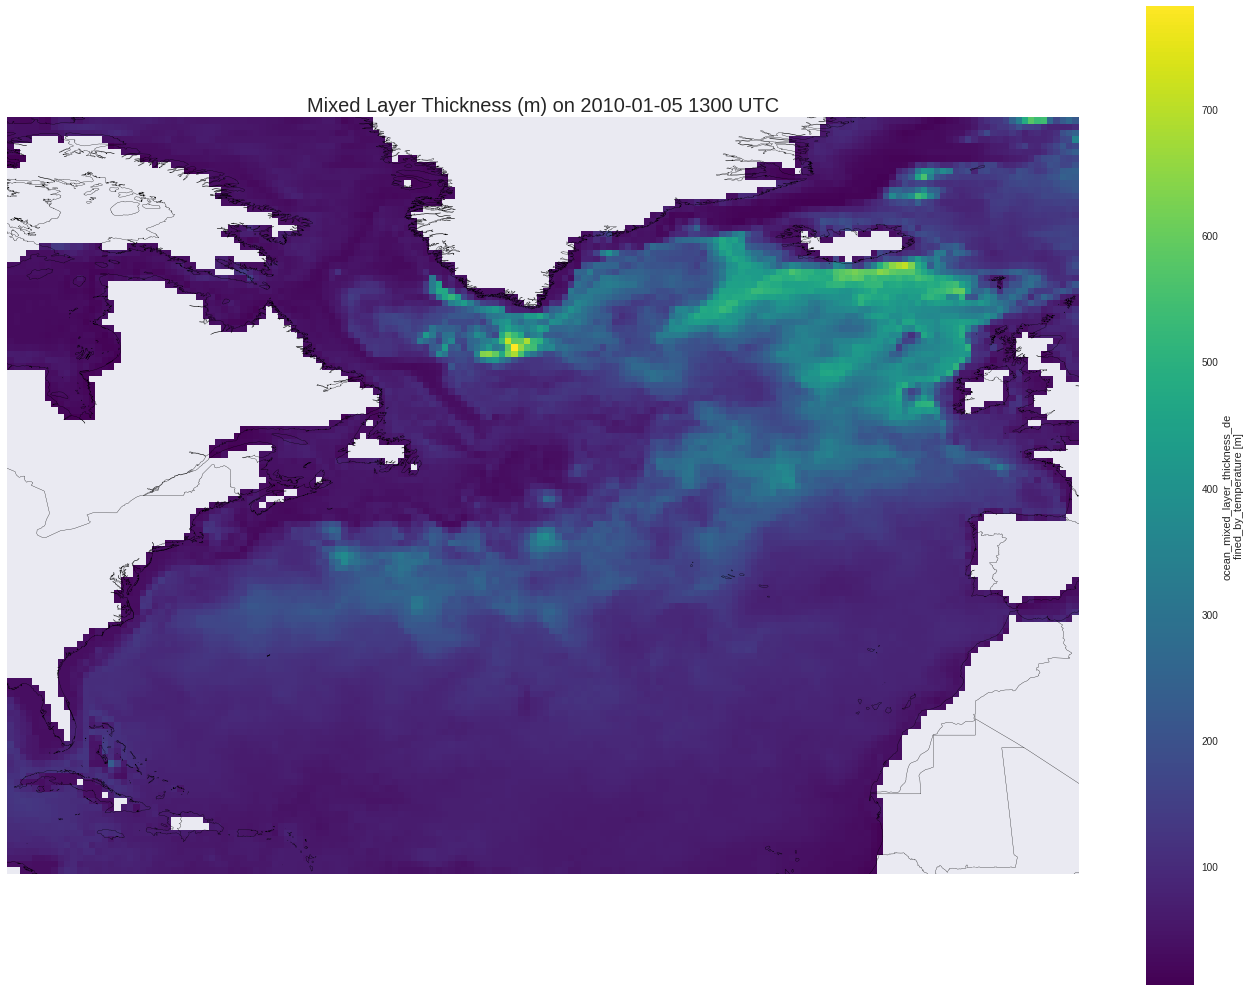

In [129]:
fig = plt.figure(figsize=(24,18))
ax = plt.axes(projection=ccrs.PlateCarree())

res='10m'
mlt.plot(ax=ax)

ax.coastlines(resolution=res)
ax.add_feature(cfeature.BORDERS.with_scale(res))

plt.title('Mixed Layer Thickness (m) on '+timeStr, fontsize = 20)

#ax.set_extent([-0, -30,30,60], ccrs.PlateCarree())

Text(0.5, 1.0, 'Sea Surface Height (m) on 2010-01-05 1300 UTC')

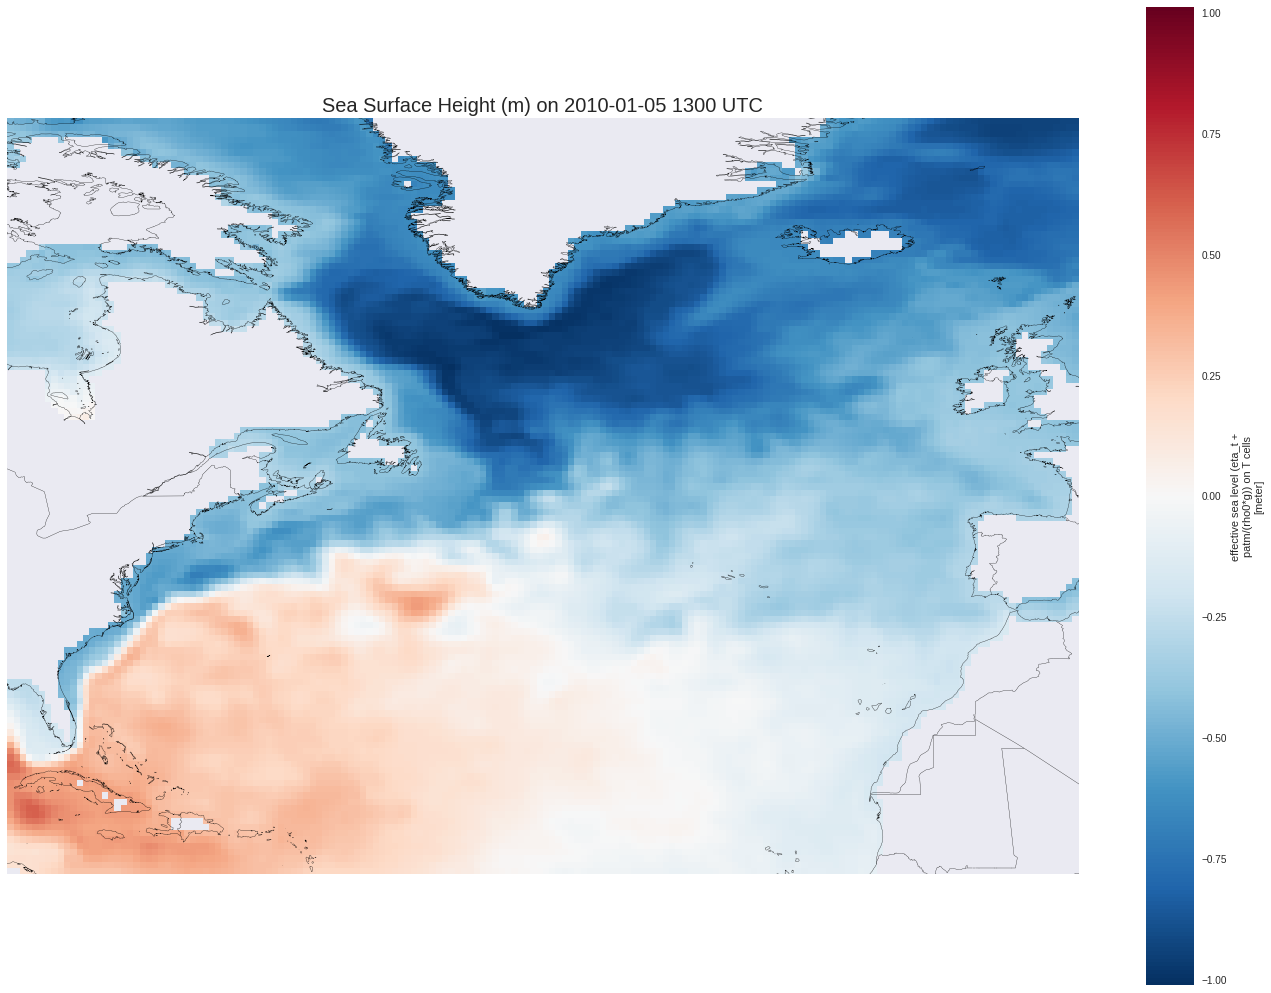

In [130]:
fig = plt.figure(figsize=(24,18))
ax = plt.axes(projection=ccrs.PlateCarree())

res='10m'
ssh.plot(ax=ax)

ax.coastlines(resolution=res)
ax.add_feature(cfeature.BORDERS.with_scale(res))

plt.title('Sea Surface Height (m) on '+timeStr, fontsize = 20)

#ax.set_extent([-0, -30,30,60], ccrs.PlateCarree())

The data I used for this section is found here: https://rda.ucar.edu/data/ds233.5/winter_latlon.txt

First, change text file to csv (dataframe). To change my methods from last time, I manually edited the text file in the Linux terminal to have Column Labels.

In [18]:
#ASI_url = "https://rda.ucar.edu/data/ds233.5/winter_latlon.txt"

#HOME = str(Path.home())
#credFile = open(HOME+'/.rdarc','r')
#userId, pw = credFile.read().split()

#session = requests.Session()
#session.auth = (userId, pw)
#ASI_txt = xr.backends.PydapDataStore.open(ASI_url, session=session)

#ASI_df = pd.read_csv(ASI_txt, sep='\s+')

#dfASI = pd.read_csv(filepath_or_buffer='https://rda.ucar.edu/data/ds233.5/winter_latlon.txt')

# I keep getting the 403 Forbidden error, so I'm just going to download the text file into my HW folder...

dfASI = pd.read_csv('/home11/ugrad/2020/ss484272/atm533/hw/final/winter_latlon.txt', sep='\s+')
dfASI.to_csv('/home11/ugrad/2020/ss484272/atm533/hw/final/winter_latlon.csv')

print(dfASI)
print(dfASI.shape)

      longitude  latitude  thickness
0        -179.5      89.5        3.0
1        -178.5      89.5        3.0
2        -177.5      89.5        3.0
3        -176.5      89.5        3.0
4        -175.5      89.5        3.0
...         ...       ...        ...
8995      175.5      65.5      168.0
8996      176.5      65.5      168.0
8997      177.5      65.5      168.0
8998      178.5      65.5      168.0
8999      179.5      65.5      168.0

[9000 rows x 3 columns]
(9000, 3)


Slice rows to shorten data

In [19]:
#dfASI=dfASI.iloc[::3]
dfASI

,longitude,latitude,thickness
0,-179.5,89.5,3.0
1,-178.5,89.5,3.0
2,-177.5,89.5,3.0
3,-176.5,89.5,3.0
4,-175.5,89.5,3.0
...,...,...,...
8995,175.5,65.5,168.0
8996,176.5,65.5,168.0
8997,177.5,65.5,168.0
8998,178.5,65.5,168.0


### Arctic Sea Ice -- Map

Now that the dataframe is ready, I can start turning this into a map.

In [20]:
lons = dfASI['longitude']
lats = dfASI['latitude']
thickness = dfASI['thickness']

lons
thickness.shape

(9000,)

TypeError: Input z must be 2D, not 1D

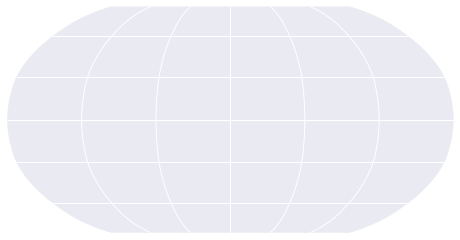

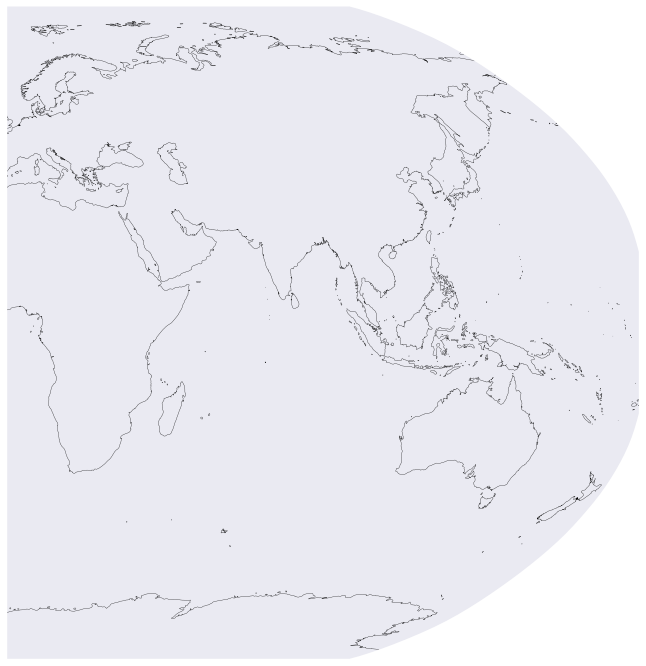

In [106]:
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))

proj_map = ccrs.Robinson()
proj_data = ccrs.Robinson()

ax.gridlines()

res='50m'

fig = plt.figure(figsize=(18,12))
ax = plt.subplot(1,1,1,projection=proj_map)
ax.set_extent ([-180,0,-90,90])
ax.add_feature(cfeature.COASTLINE.with_scale(res))
CF = ax.contour(lons,lats,thickness, transform=proj_data,cmap=plt.get_cmap('coolwarm'))
cbar = plt.colorbar(CF,shrink=0.5)
cbar.ax.tick_params(labelsize=16)
cbar.ax.set_ylabel("Height (dam)",fontsize=16)


#ax.pcolor(lons,lats,thickness,cmap='winter')

#ax.scatter(lons,lats,c=thickness,cmap='coolwarm')


#dfASI.thickness.plot();